### Import data

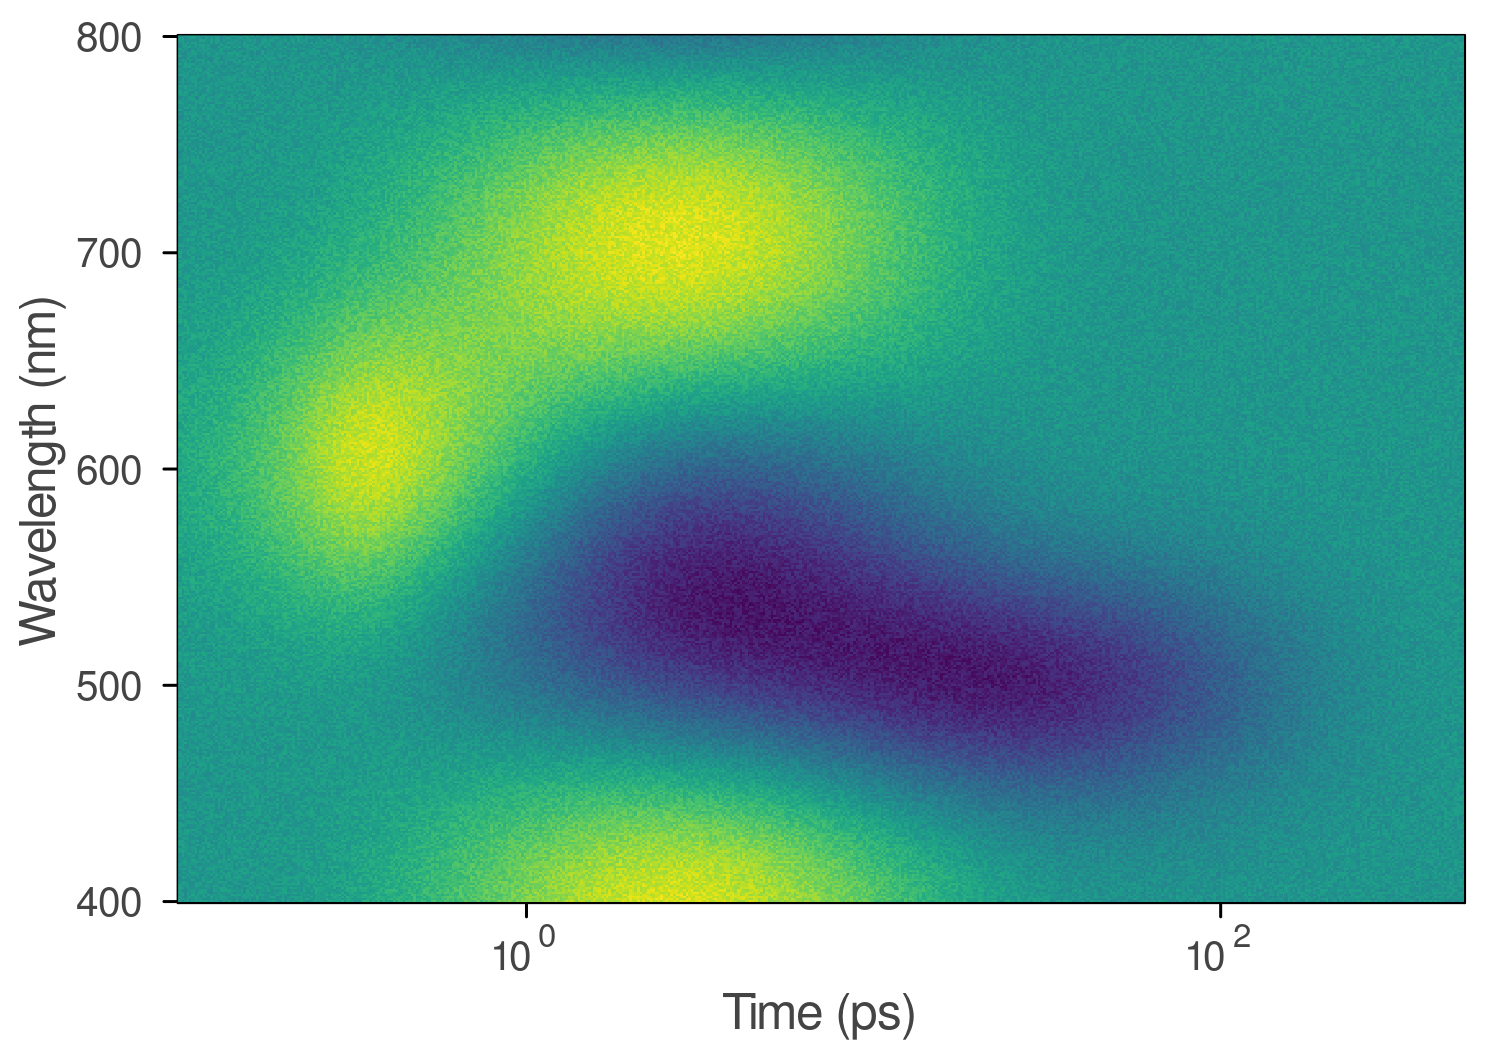

In [25]:
include("../src/DataImport.jl")
include("../src/plots.jl")

# define .csv file containing experimental data
file = raw"C:\OneDrive - Stanford\Data\Git\GlobalAnalysis.jl\testdat_1o_seq.csv"

# import data
data = importData(file)[1]
# spectral dimension
s = data.x
# time dimension
t = data.y
# 2D data
d = data.z

# plot dataset for quick overview
tBl = t .> 0
heatmap(t[tBl], s, d[:,tBl], xscale=:log10, c=:viridis,
    xlabel="Time (ps)", ylabel="Wavelength (nm)")


### Define kinetic model

In [26]:
include("../src/kinetic.jl")

# define kinetic model
rn = @reaction_network begin
    k1, A --> B
    k2, B --> C
    k3, C --> 0
end

# define starting values and bounds for the parameter optimization 
limits = Dict(
    :A => 1,
    :B => 0,
    :C => 0,
    :k1 => [0.5, 5],
    :k2 => [0.05, 0.5],
    :k3 => [0.005, 0.05],
    :μ => [-0.5, 0.5],
    :σ => [0.04, 0.2]
)

# show reaction network
using Latexify
latexify(rn)

L"\begin{align*}
\mathrm{A} &\xrightarrow{k1} \mathrm{B} \\
\mathrm{B} &\xrightarrow{k2} \mathrm{C} \\
\mathrm{C} &\xrightarrow{k3} \varnothing  
 \end{align*}
"

### Run the optimization

In [27]:
# maximum number of iterations
maxIter = 100

# generate bounds for fit parameters
bounds = generateBoundsMH(rn, limits)

# run optimization
using Metaheuristics
options = Options(iterations=maxIter, parallel_evaluation=true)
result = Metaheuristics.optimize((param)->simulateDataParallel(t, rn, param, limits, d),
    bounds, DE(N=10;options))


Optimization Result
===================
  Iteration:       100
  Minimum:         799.159
  Minimizer:       [1.00463, 0.100012, 0.0100239, …, 0.100073]
  Function calls:  1000
  Total time:      3.6680 s
  Stop reason:     Maximum number of iterations exceeded.

### Get optimized parameters and fit data

In [28]:
# get optimized parameters
fitParam = minimizer(result)



5-element Vector{Float64}:
 1.0046288673315615
 0.10001193344923916
 0.010023890584571477
 0.20018624919734415
 0.1000730518199239

In [29]:
# get best fit data
fitData, fitSpc, fitKin = simulateData(t, rn, fitParam, limits, d; ret="kin")

([0.0 0.0 … -0.00029944335909141734 -0.00027503938733137653; 0.0 0.0 … -0.00047731546627682164 -0.0004384153110187657; … ; 0.0 0.0 … -2.7387308092798815e-5 -2.515530303077995e-5; 0.0 0.0 … -3.503256951125866e-5 -3.217749254569081e-5], [0.0032110315152060137 0.9766049216669258 -0.03701083402742056; -0.020021758721974828 0.9981705450565623 -0.05899560956935144; … ; -0.005977574445687301 -0.2721275080729956 -0.0033850378828104103; 0.000812099413930892 -0.2941459070445455 -0.004329982871116131], [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 2.728621000733189e-18 -3.0302899751520257e-18 0.008090694710353272; 6.310580138723258e-19 -7.008260954521414e-19 0.007431320978273683])

### Plot optimized kinetics

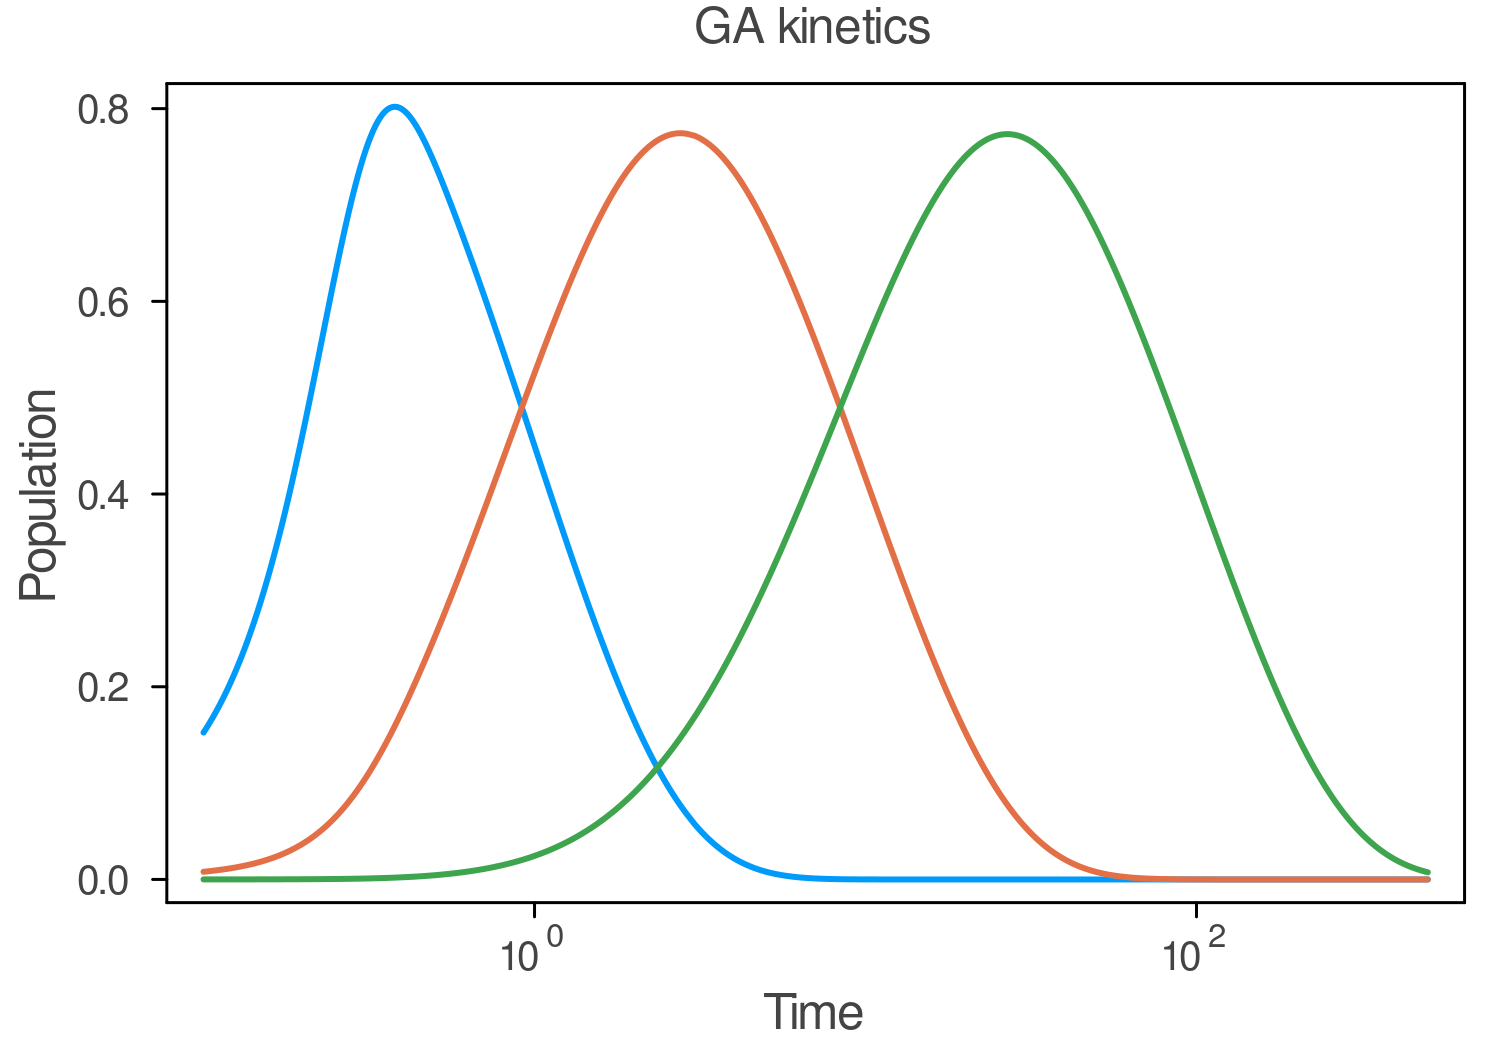

In [30]:
# positive times for log plot
tBl = t .> 0

# plot kinetics
plot(t[tBl], fitKin[tBl,:], xscale=:log10, title="GA kinetics", 
xlabel="Time", ylabel="Population")

### Plot optimized spectral signatures

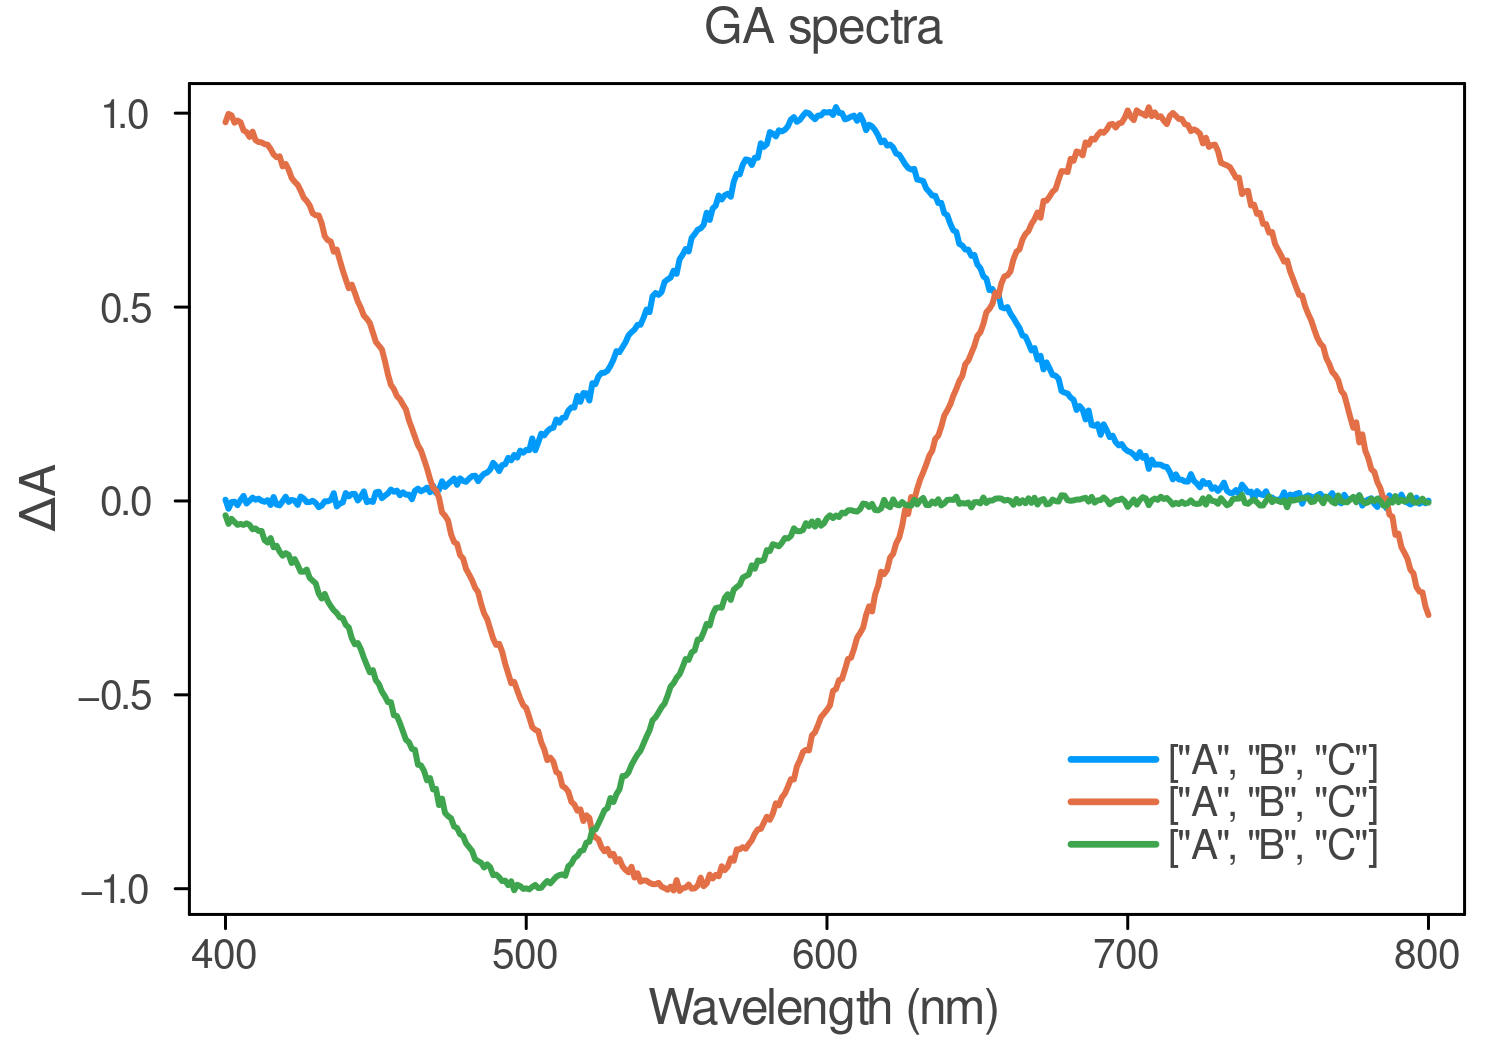

In [31]:
plot(s, fitSpc, title="GA spectra", 
xlabel="Wavelength (nm)", ylabel="ΔA", label=string.(getSpecies(rn)), legend=true)

### Plot fit residuals

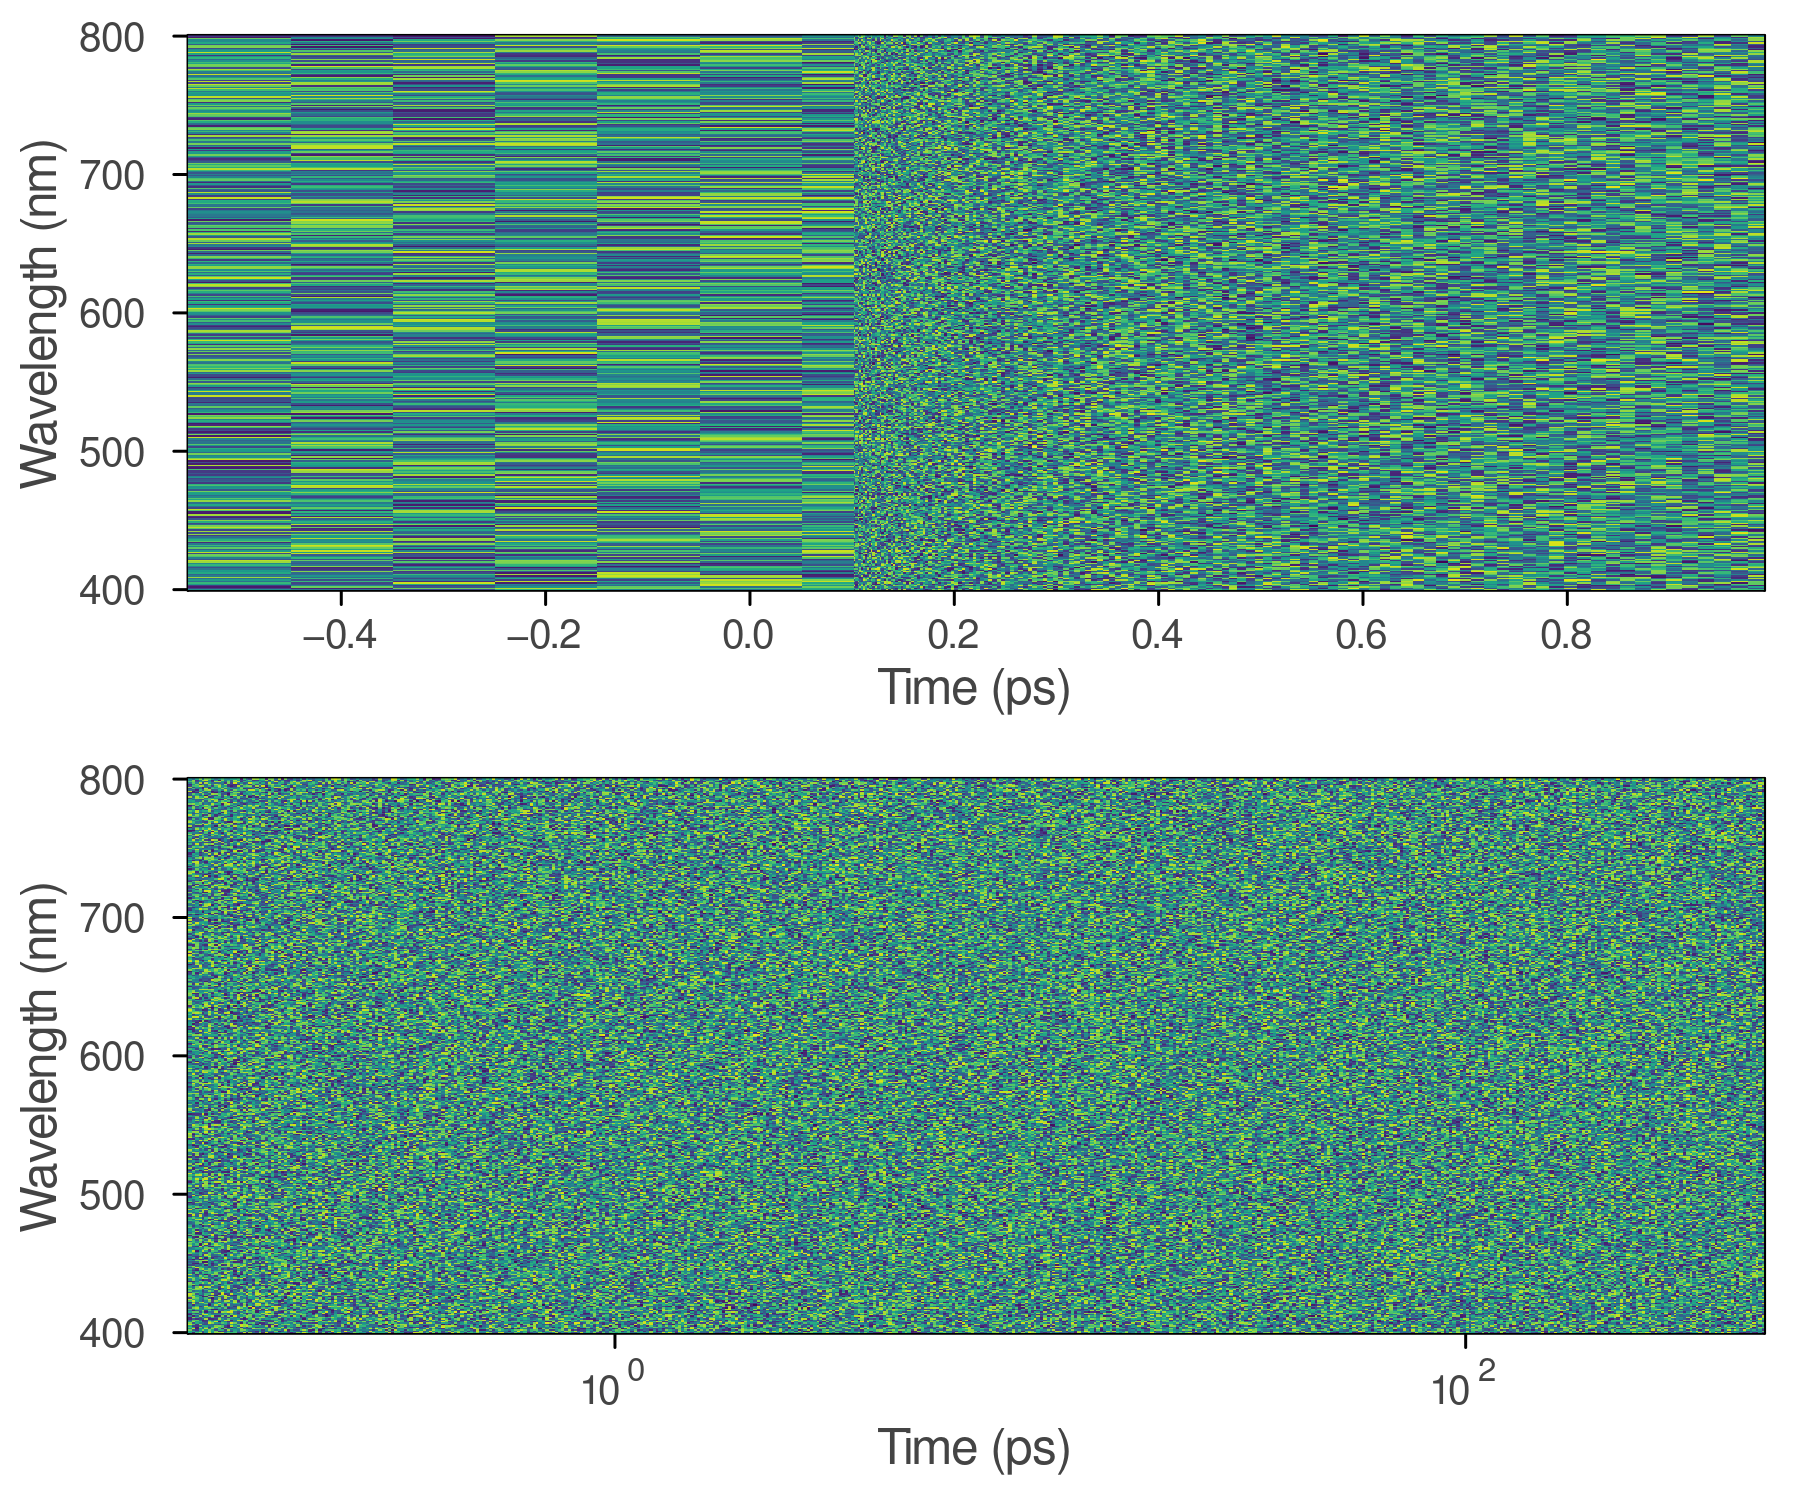

In [32]:
# linear plot around t = 0
tBl = -0.5 .≤ t .≤ 1
p1 = heatmap(t[tBl], s, d[:,tBl] .- fitData[:,tBl], c=:viridis,
    xlabel="Time (ps)", ylabel="Wavelength (nm)")

# log plot at positive times
tBl = t .> 0
p2 = heatmap(t[tBl], s, d[:,tBl] .- fitData[:,tBl], c=:viridis,
    xscale=:log10, xlabel="Time (ps)", ylabel="Wavelength (nm)")

# combine plots
plot(p1,p2, layout=(2,1), size=(600,500))